## The SSR Under QR Heston

We use `QRH.blip` to compute the SSR under quadratic rough Heston by blipping.

$$
\newcommand{\E}{\mathbb{E}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\sigl}{\sigma_L}
\newcommand{\BS}{\rm BS}
\newcommand{\VIX}{\rm VIX}
\newcommand{\p}{\partial}
\newcommand{\var}{{\rm var}}
\newcommand{\cov}{{\rm cov}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\bea}{\begin{eqnarray}}
\newcommand{\eea}{\end{eqnarray}}
\newcommand{\ben}{\begin{enumerate}}
\newcommand{\mP}{\mathbb{P}}
\newcommand{\een}{\end{enumerate}}
\newcommand{\ee}[1]{{\mathbb{E}\left[{#1}\right]}}
\newcommand{\eef}[1]{{\mathbb{E}\left[\left.{#1}\right|\cF_t\right]}}
\newcommand{\angl}[1]{{\langle{#1}\rangle}}
\newcommand{\mt}{\mathbf{t}}
\newcommand{\mS}{\mathbf{S}}
\newcommand{\tC}{\widetilde{C}}
\newcommand{\hC}{\widehat{C}}
\newcommand{\tH}{\widetilde{H}}
\newcommand{\cD}{\mathcal{D}}
\newcommand{\cS}{\mathcal{S}}
\newcommand{\cR}{\mathcal{R}}
\newcommand{\cF}{\mathcal{F}}
\newcommand{\cV}{\mathcal{V}}
\newcommand{\cG}{\mathcal{G}}
\newcommand{\cv}{\mathcal{v}}
\newcommand{\cg}{\mathcal{g}}
\newcommand{\cH}{\mathcal{H}}
\newcommand{\cK}{\mathcal{K}}
\newcommand{\dm}{\diamond}
$$

In [3]:
## The required packages
library(gsl)
library(foreach)
library(doParallel)
library(colorspace)
library(MittagLeffleR)
library(statmod)
library(stinepack)
library(repr)


Warning message:
"package 'doParallel' was built under R version 4.0.5"
Loading required package: iterators

Loading required package: parallel



In [4]:
source("gammaKernel.R")
source("QRHGammaYFromXi.R")
source("QRHsimulation.R")
source("BlackScholes.R")


In [44]:
bl <- "royalblue"
rd <- "red2"
pk <- "hotpink1"
gr <- "green4"
br <- "brown"
pu <- "purple"


In [7]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 150)


### Gamma kernel

The gamma kernel is given by
$$
\kappa(\tau)= \frac{\nu}{\Gamma(\alpha)} \, \tau^{\alpha-1}\,e^{-\lambda \tau},
$$

with $\alpha = H + \tfrac12$.

In [8]:
params0 <- list(al = 0.568, lam = 9.68, eta = 0.99, c = 8.1e-3)


### Initial forward variance curve $\xi_t(u)$

In [19]:
load(file = "xi20230215.rData")


In [ ]:
xi <- xiCurveObj$getForwardVarCurve()


In [23]:
# xi <- xiCurveObj$get_forward_var_curve()


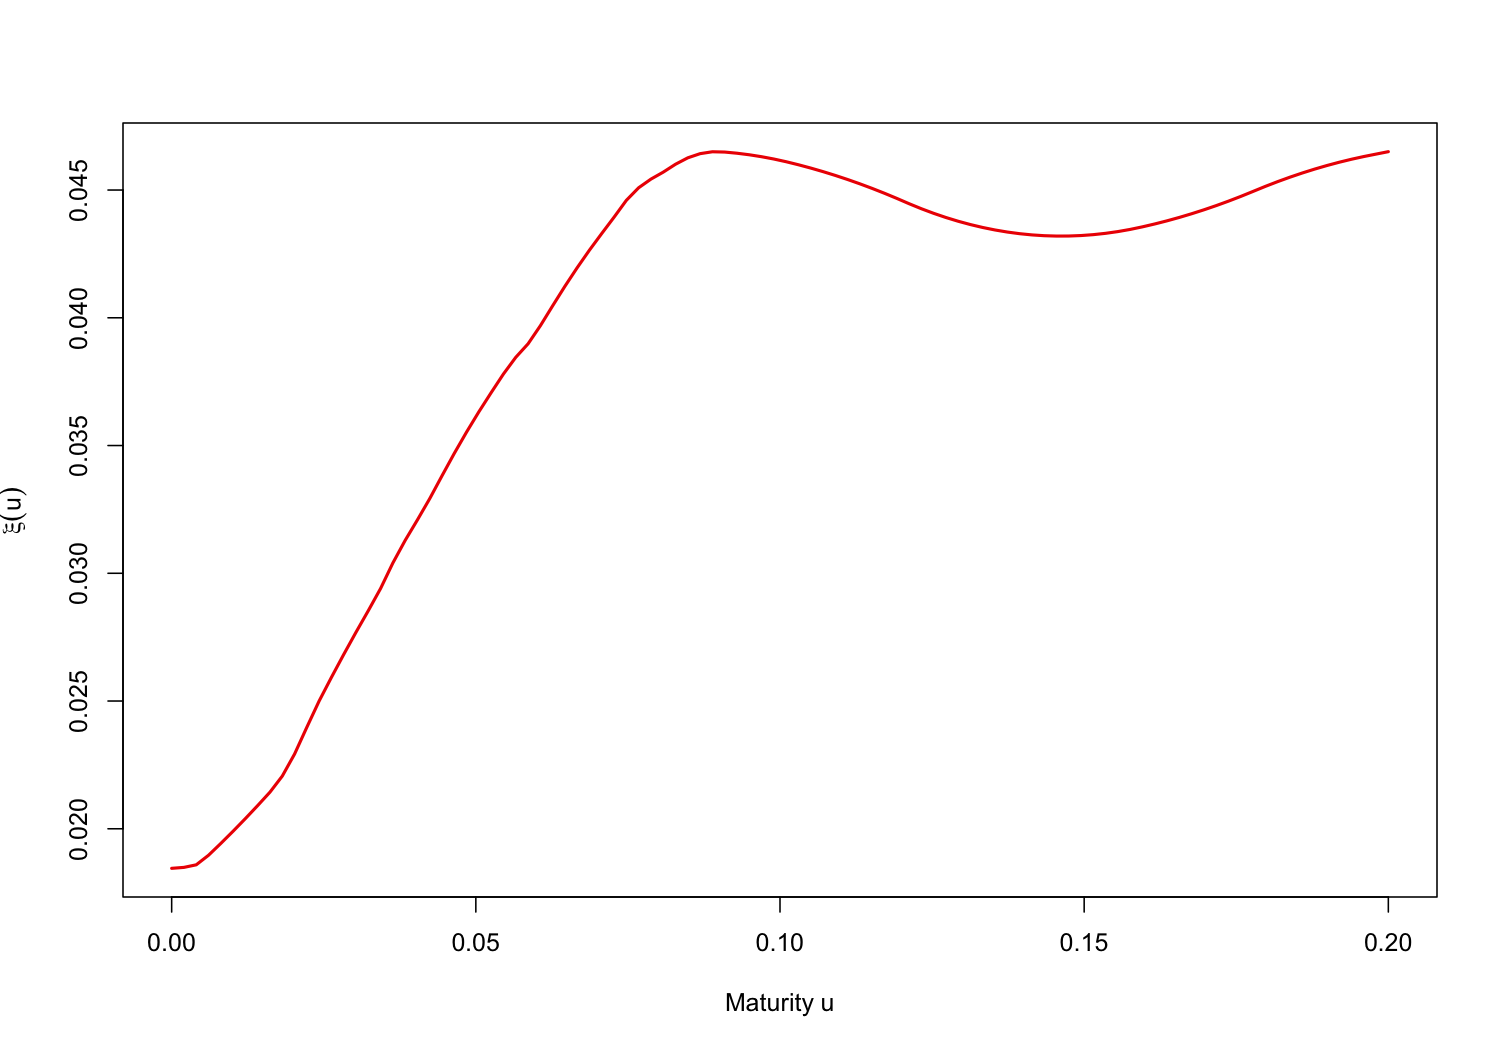

In [24]:
curve(xi, from = 0, to = .2, col = "red2", n = 100, lwd = 2, xlab = "Maturity u", ylab = expression(xi(u)))


### $y_t(u)$ from $\xi_t(u)$

$$
y_t(u)^2= \xi_t(u) - c -  \int_t^u\,\xi_t(s)\,\kappa (u-s)^2\,ds.
$$

Integration is performed using Gauss-Jacobi quadrature.

In [25]:
ey <- yFromXi(params0, xi)


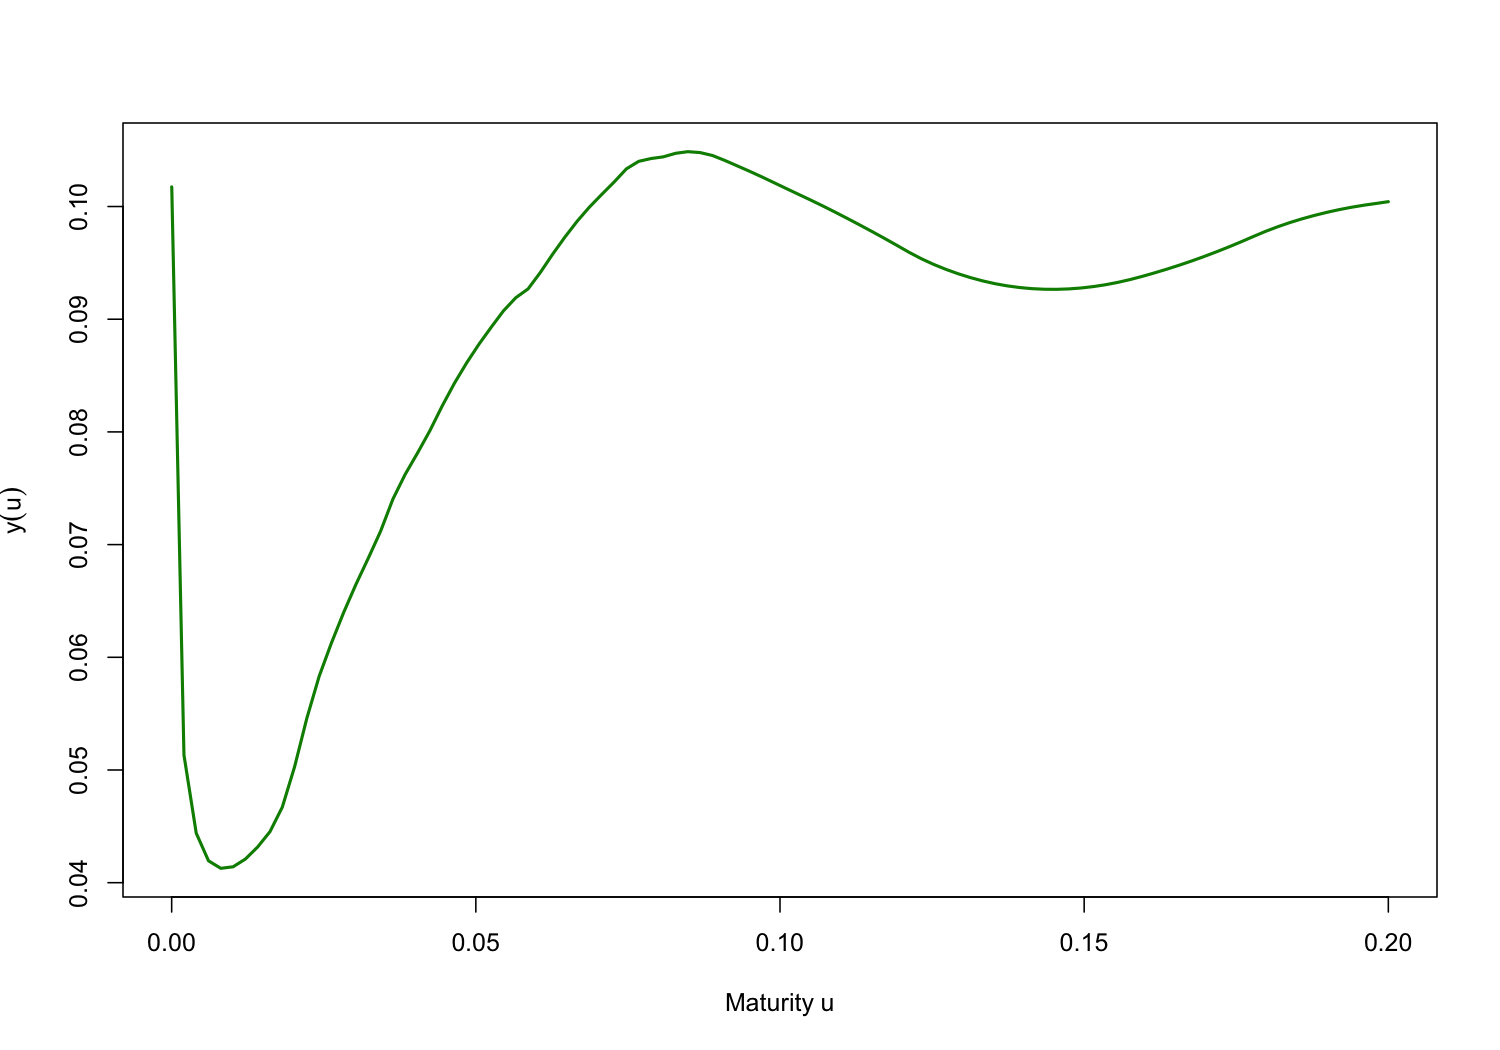

In [26]:
curve(ey, from = 0, to = .2, n = 100, col = "green4", lwd = 2, xlab = "Maturity u", ylab = expression(y(u)))


### The SSR under quadratic rough Heston

Recall that in forward volatility form, the QR Heston model reads:

$$
dy_t(u) = \kappa(u-t)\,\sqrt{V_t}\,dW_t.
$$


We may then apply the finite difference methodology of Bourgey et al. to approximate 
the SSR. Specifically, the regression coefficient is given by

\begin{equation}
    \beta_{t}(T)
    \approx \frac 1 h\,\left\{
    \sigma_{t}\left(T,y^h_{t}(\cdot)\right )
    -
    \sigma_{t}\left( T, y^{}_{t}(\cdot)\right)
    \right\},
\end{equation}
    
where $h$ is a small parameter and for $t \leq u \leq T$,
$$
    y^h_{t}(u) := y_t(u) - h\,\kappa(u-t),
$$

where we have used that the spot-vol correlation in our model is $-1$.

The SSR is then estimated as
$$
    \mathcal{R}_{t}(T) \approx \frac{\beta_t(T)}{\mathcal{S}_t(T)},
$$
where $\mathcal{S}_t(T)$ is the ATM skew.

#### Blipped forward volatility curves

Experiment shows that scaling the blip by time to expiration works well.  Specifically, we choose $h=-0.01 \sqrt{T}$;  $h<0$  ensures a positive blipped forward variance curve.

### Run `QRH.blip` in parallel

Note that Figure 3 in the paper has more expiries, 300,000 paths, and 300 time steps.  We have reduced the computational burden here for illustration.  

In [27]:
paths <- 100000
steps <- 100
h <- -.01


In [28]:
(expiries <- 2^(((-13):(0)) / 2))


[1] 0.01104854 0.01562500 0.02209709 0.03125000 0.04419417 0.06250000
 [7] 0.08838835 0.12500000 0.17677670 0.25000000 0.35355339 0.50000000
[13] 0.70710678 1.00000000

In [29]:
t0 <- proc.time()

# Number of iterations
iters <- max(1, floor(paths / 10000))

# Setup parallel backend to use all processors
(cl.num <- detectCores()) # Display number of processors on your machine
cl <- makeCluster(cl.num)
registerDoParallel(cl)

# Load packages on all workers
invisible({
    clusterEvalQ(cl, {
        library(statmod)
        library(MittagLeffleR)
    })
})

# Loop
ls <- foreach(icount(iters)) %dopar% {
    QRH.blip(params0, xi, h)(paths = 10000, steps = steps, expiries = expiries)
}

stopCluster(cl)
mcMatrix <- do.call(cbind, ls) # Bind all of the submatrices into one big matrix

print(proc.time() - t0)


[1] 8

   user  system elapsed 
  0.421   0.325  48.344 


### Compute  base and blipped implied volatilities

First we construct a matrix of $S_T$ values from the output of `QRH.blip`.

In [30]:
nn <- length(expiries)


In [31]:
ST <- matrix(nrow = nn, ncol = paths)
ST.h <- matrix(nrow = nn, ncol = paths)


In [32]:
for (j in 1:nn) {
    ST[j, ] <- exp(-mcMatrix[4 + 8 * (j - 1), ] - mcMatrix[2 + 8 * (j - 1), ] / 2)
    ST.h[j, ] <- exp(-mcMatrix[8 + 8 * (j - 1), ] - mcMatrix[6 + 8 * (j - 1), ] / 2)
}


#### Illustrate for one expiration

In [33]:
kk <- seq(-.4, .2, .001)


In [34]:
vol.kk <- bsOut(ST[9, ], expiries[9], exp(kk))$BSV
vol.h.kk <- bsOut(ST.h[9, ], expiries[9], exp(kk))$BSV


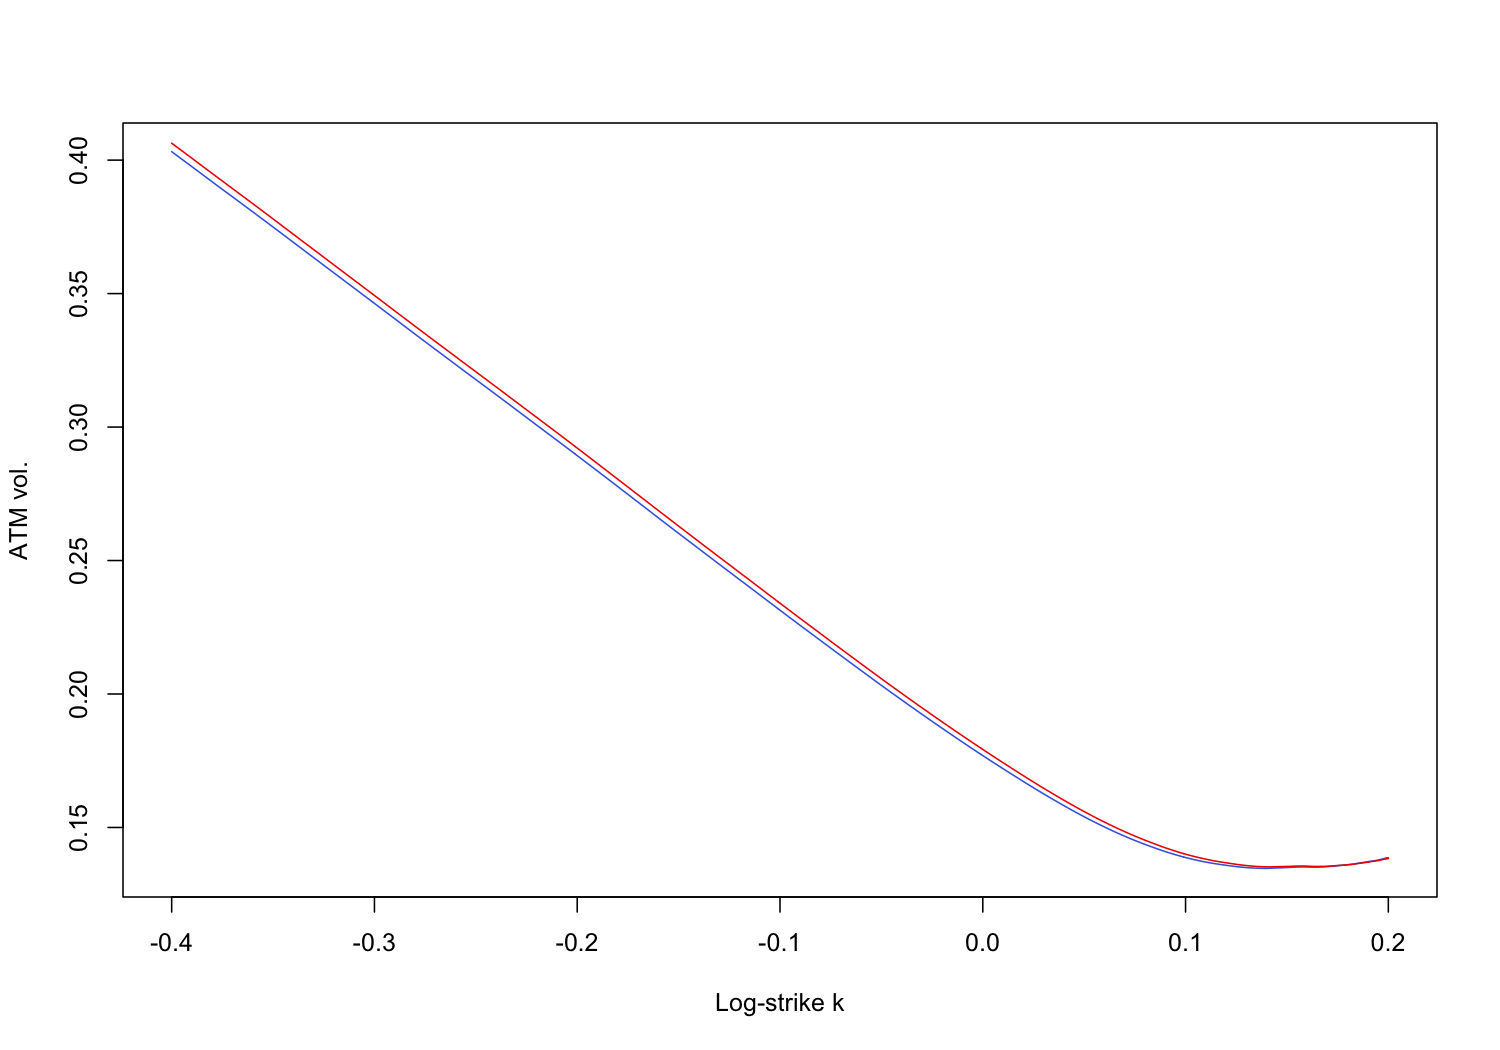

In [35]:
plot(kk, vol.kk, pch = 20, col = bl, type = "l", xlab = "Log-strike k", ylab = "ATM vol.")
lines(kk, vol.h.kk, col = rd)


### Computation of the regression coefficient $\beta$

In [36]:
beta <- numeric(nn)

for (j in 1:nn) {
    beta[j] <- (bsOut(ST.h[j, ], expiries[j], 1)$BSV - bsOut(ST[j, ], expiries[j], 1)$BSV) / .01 / sqrt(expiries[j])
}


#### Log-log plot of $\beta_t(T)$

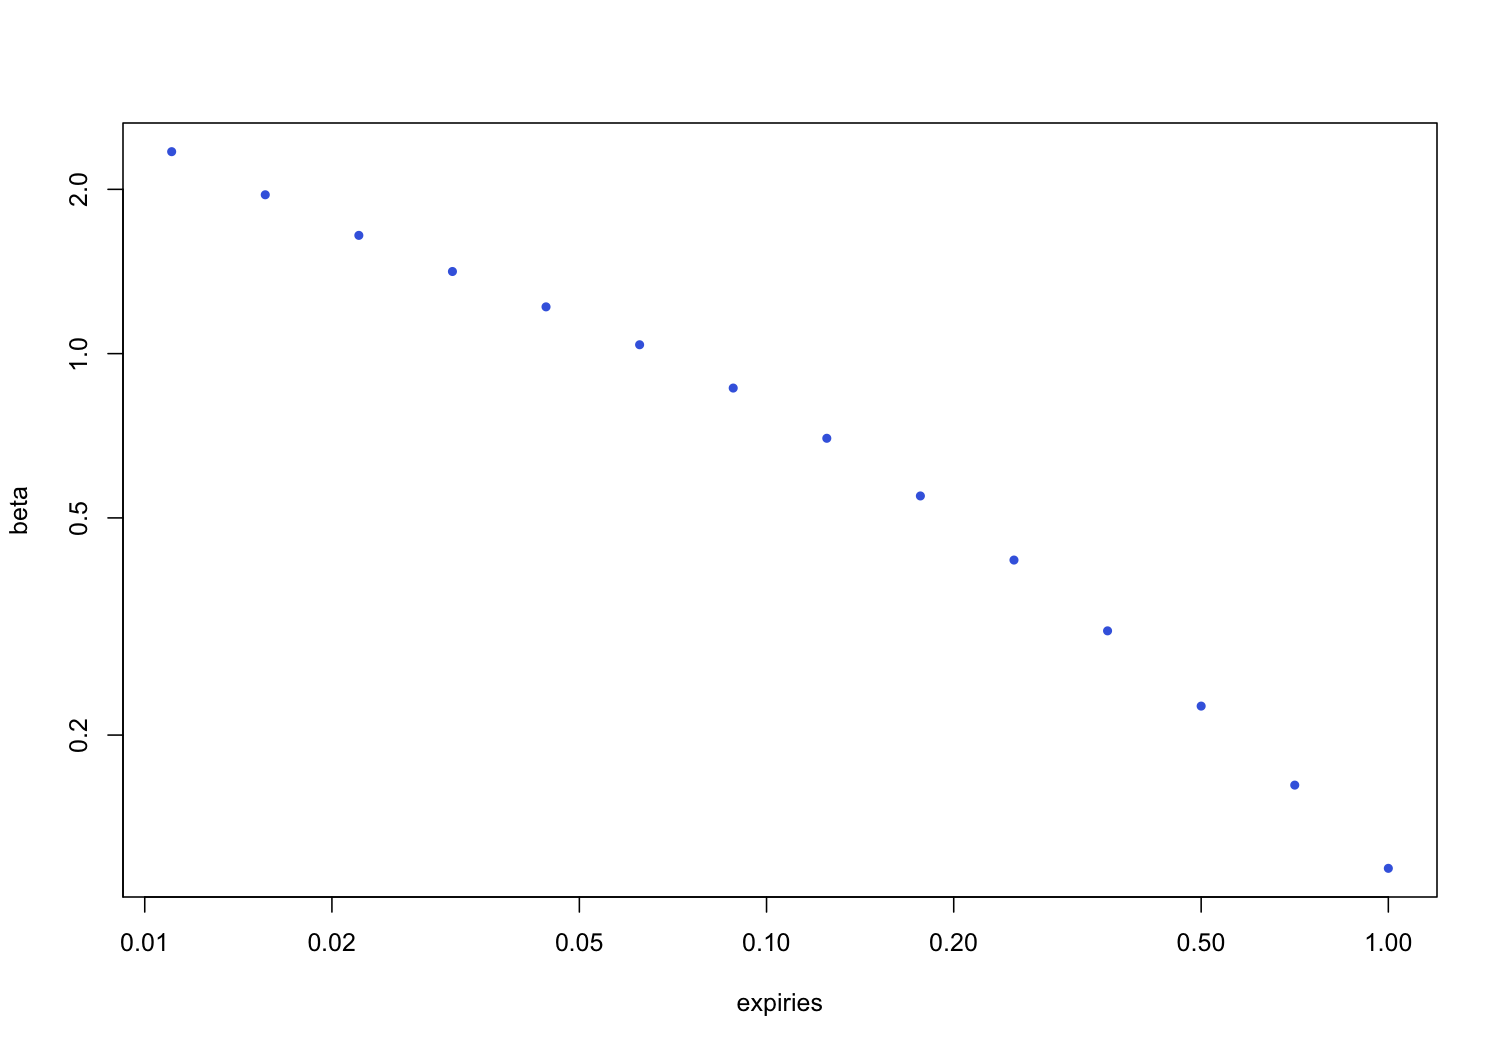

In [37]:
plot(expiries, beta, pch = 20, col = bl, log = "xy")


### Skew computation

We can estimate the ATM skew 
$\mathcal{S}(\tau) = \left. \frac{\partial \sigma_{\text{BS}}(k,T)}{\partial k}\right|_{k=0}$  by Monte Carlo using the following implied volatility skew representation,
$$
    \frac{\partial \sigma_{\text{BS}}(k,T)}{\partial k}
    =
    \left. \frac{\Phi\left(-\frac{k}{\sqrt{w}} - \frac{\sqrt{w}}{2}\right) - \mathbb P\left(X_T \geq k\right)}{\sqrt{T} \phi\left(-\frac{k}{\sqrt{w}} - \frac{\sqrt{w}}{2}\right)} \right|_{w=T \sigma_{\text{BS}}^2(k,T)}
$$
where $\phi$ is the PDF of a standard normal distribution.

In [38]:
pr <- numeric(nn)
skew <- numeric(nn)
pr.h <- numeric(nn)
skew.h <- numeric(nn)


In [39]:
for (j in 1:nn) {
  Xj <- mcMatrix[4 + 8 * (j - 1), ] - mcMatrix[2 + 8 * (j - 1), ] / 2
  pr[j] <- mean(Xj >= 0)
  Xj <- mcMatrix[8 + 8 * (j - 1), ] - mcMatrix[2 + 8 * (j - 1), ] / 2
  pr.h[j] <- mean(Xj >= 0)
}


In [40]:
for (j in 1:nn) {
  wj <- mean(mcMatrix[2 + 8 * (j - 1), ])
  Phij <- pnorm(-sqrt(wj) / 2)
  phij <- dnorm(-sqrt(wj) / 2)
  skew[j] <- (Phij - pr[j]) / sqrt(expiries[j]) / phij
  wj <- mean(mcMatrix[6 + 8 * (j - 1), ])
  Phij <- pnorm(-sqrt(wj) / 2)
  phij <- dnorm(-sqrt(wj) / 2)
  skew.h[j] <- (Phij - pr[j]) / sqrt(expiries[j]) / phij
}


#### Log-log plot of $\mathcal{S}_t(T)$

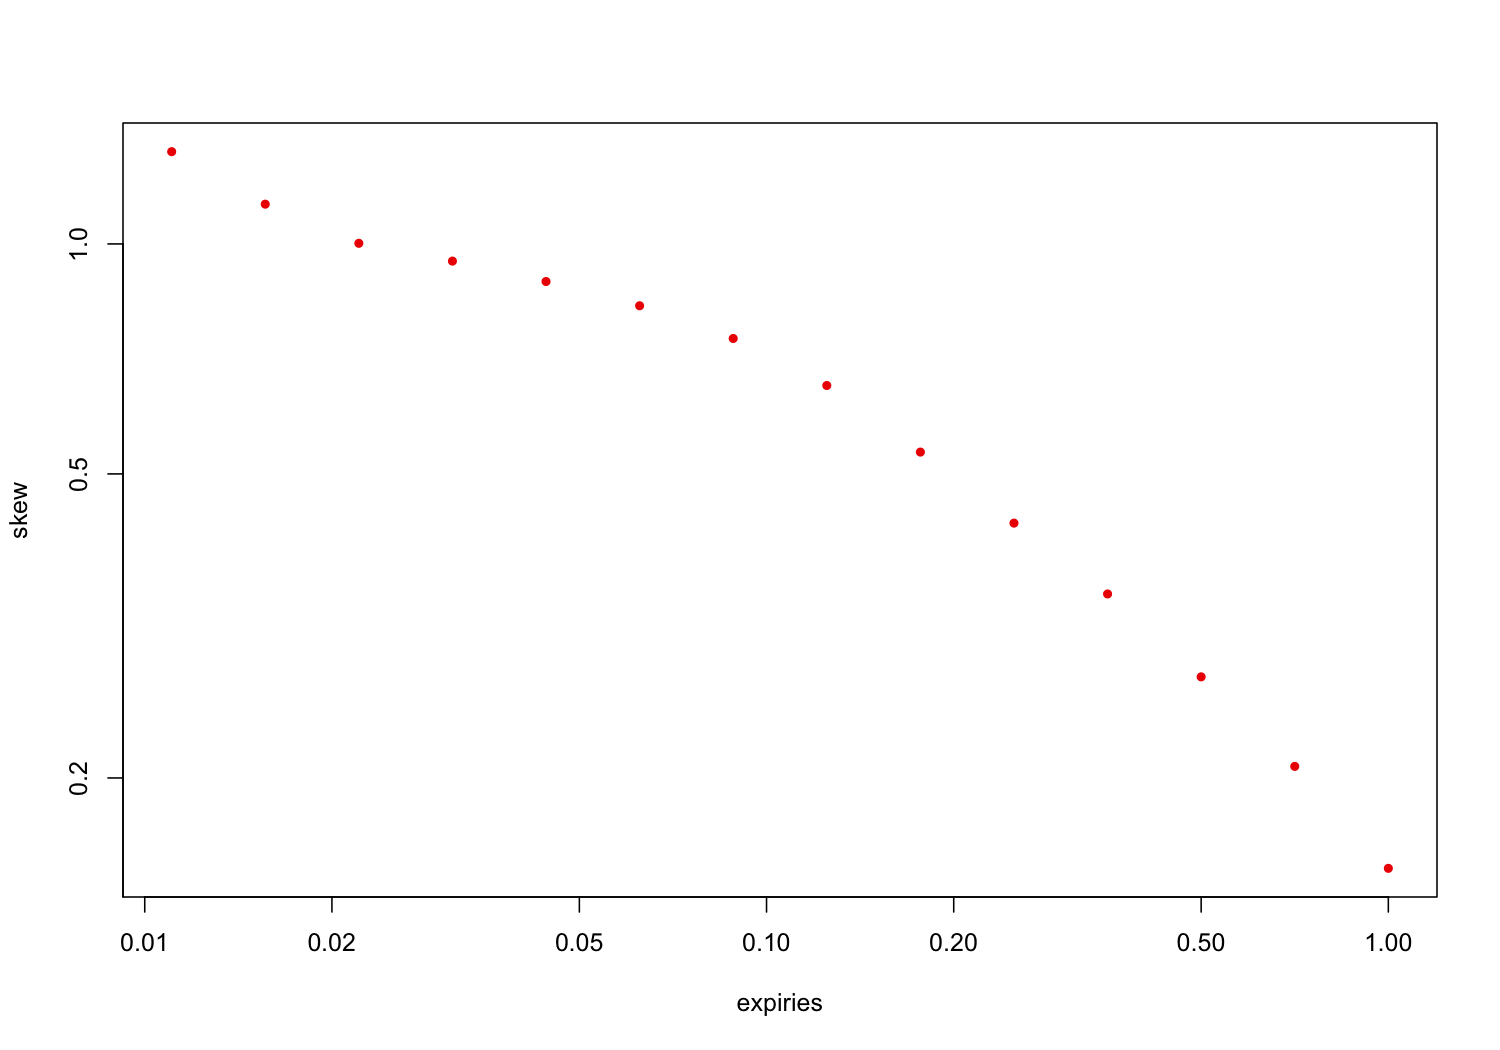

In [41]:
plot(expiries, skew, pch = 20, col = rd, log = "xy")


In [42]:
(ssr <- beta / skew)


[1] 1.7754901 1.7340220 1.6439231 1.4892909 1.3642751 1.2507673 1.1499315
 [8] 1.0719588 1.0271755 0.9708956 0.8916095 0.8332488 0.7819012 0.7483553

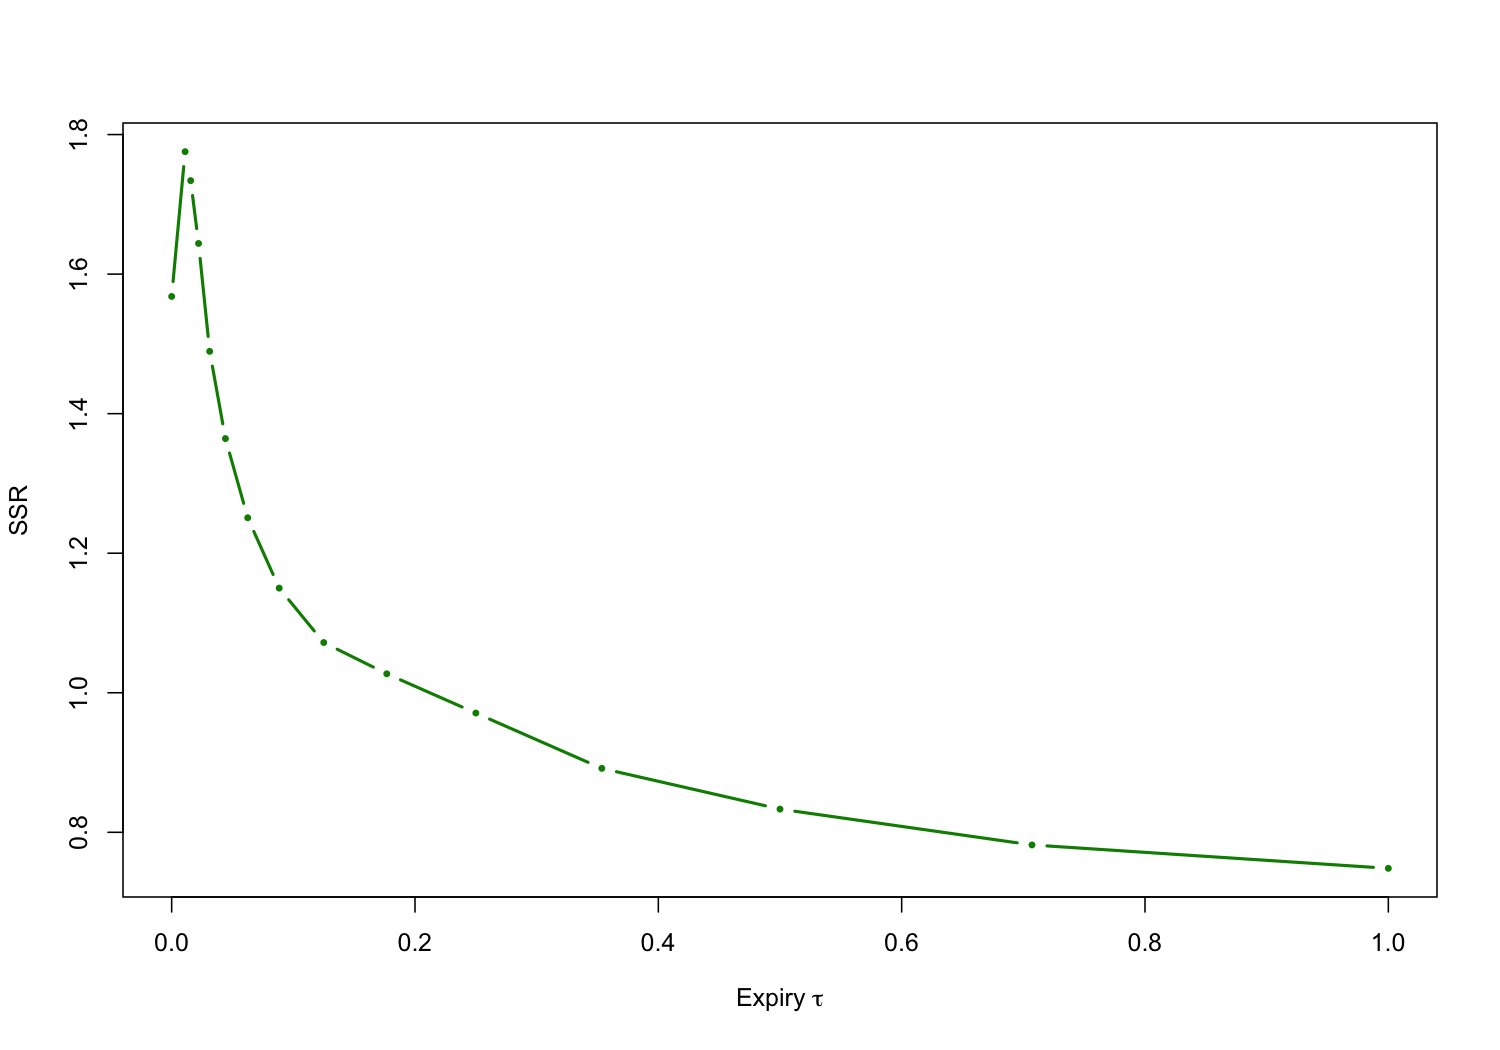

In [43]:
plot(c(0, expiries), c(params0$al + 1, ssr),
    pch = 20, col = gr, type = "b", lwd = 2, cex = .5,
    ylab = "SSR", xlab = expression(paste("Expiry ", tau))
)
